In [2]:
import qutip
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from scipy.optimize import curve_fit
from scipy.linalg import expm
from sympy import *
init_printing()
#jtplot.style(theme='chesterish',ticks=True, grid=True, figsize=(12, 7),context='poster',fscale=1.5, spines=True, gridlines='--')
jtplot.style(theme='grade3',ticks=True, grid=True, figsize=(12, 7),context='poster',fscale=1.5, spines=True, gridlines='--')
%matplotlib inline

In [3]:
J=0.1*2*np.pi*2020
def strtransferstate(string):
    state=0
    for a in string:
        tmp=1-int(a)
        if state==0:
            state=qutip.basis(2,tmp)
        else:
            state=qutip.tensor(state,qutip.basis(2,tmp))
    return state

def allstates(n):
    a=[]
    if n==1:
        return ['1','0']
    else:
        for i in ['0','1']:
            a+=[i+o for o in allstates(n-1)]
        return a
    
def tsqtindtostate(n):
    strb=allstates(n)
    indexstate=[0]*len(strb)
    for i in range(len(strb)):
        state=strtransferstate(strb[i]).full()
        indexstate[np.argmax(state)]=strb[i]
    indexstate=np.array(indexstate)
    return indexstate
    
def splittosys(n):
    s = np.array(range(n))
    sets=set(s)
    coup1=[]
    coup2=[]
    for i in range(2**n):
        e = list(bin(i))[2:]
        e = np.array(e) == '1'
        tmp=s[n-len(e):][e]
        tmp=set(tmp)
        tmpb=sets-tmp
        if len(tmp)!=0 and len(tmp)!=n and (tmpb not in coup1):
            coup1.append(tmp)
            coup2.append(tmpb)
    return coup1,coup2

def entropycheck(state,oc):
    #s=(qutip.ket2dm(state)*qutip.ket2dm(state)).tr()
    t1=(state.ptrace(oc)*state.ptrace(oc)).tr()
    return t1
    
def genham(n,J):
    h1=-J*(qutip.tensor(qutip.sigmax(),qutip.sigmax())+qutip.tensor(qutip.sigmay(),qutip.sigmay()))-J*qutip.tensor(qutip.sigmaz(),qutip.sigmaz())
    hamodd=0
    hameven=0
    for i in range(n-1):
        if i==0:
            if n>2:
                s=[qutip.qeye(2)]*(n-2)
                hameven+=qutip.tensor(h1,qutip.tensor(*s))
            else:
                hameven+=h1
        elif i==n-2:
            s=[qutip.qeye(2)]*(n-2)
            hameven+=qutip.tensor(qutip.tensor(*s),h1)
        else:
            s1=[qutip.qeye(2)]*i
            s2=[qutip.qeye(2)]*(n-2-i)
            if i%2==0:
                hameven+=qutip.tensor(qutip.tensor(*s1),h1,qutip.tensor(*s2))
            else:
                hamodd+=qutip.tensor(qutip.tensor(*s1),h1,qutip.tensor(*s2))
    return hamodd,hameven
    #print(tmp)

def singleration(theta):
    rotationmatrix=np.array([(np.cos(theta/2),np.sin(theta/2)),(np.sin(theta/2),-np.cos(theta/2))])
    return qutip.Qobj(rotationmatrix)
    
def staterotation(n,singlerotation):
    allrataion=[singlerotation]*n
    wholerotate=qutip.tensor(*allrataion)
    return wholerotate

def totalspinoperator(n):
    s=0.5*qutip.sigmaz()
    tmp=qutip.qeye(2)
    if n==1:
        return s
    else:
        others=[tmp]*(n-1)
        totalspin=qutip.tensor(s,*others)
        for i in range(1,n-1):
            others0=[tmp]*i
            others1=[tmp]*(n-i-1)
            totalspin+=qutip.tensor(*others0,s,*others1)
        totalspin+=qutip.tensor(*others,s)
        return totalspin
    
def totalspinyoperator(n):
    s=0.5*qutip.sigmay()
    tmp=qutip.qeye(2)
    if n==1:
        return s
    else:
        others=[tmp]*(n-1)
        totalspiny=qutip.tensor(s,*others)
        for i in range(1,n-1):
            others0=[tmp]*i
            others1=[tmp]*(n-i-1)
            totalspiny+=qutip.tensor(*others0,s,*others1)
        totalspiny+=qutip.tensor(*others,s)
        return totalspiny
        
        
def totalspinxoperator(n):
    s=0.5*qutip.sigmax()
    tmp=qutip.qeye(2)
    if n==1:
        return s
    else:
        others=[tmp]*(n-1)
        totalspinx=qutip.tensor(s,*others)
        for i in range(1,n-1):
            others0=[tmp]*i
            others1=[tmp]*(n-i-1)
            totalspinx+=qutip.tensor(*others0,s,*others1)
        totalspinx+=qutip.tensor(*others,s)
        return totalspinx
    
def totalspinpar(n,par):
    s=0.5*qutip.sigmaz()
    tmp=qutip.qeye(2)
    if n==1:
        return s
    else:
        others=[tmp]*(n)
        totalspin=qutip.tensor(*others)
        for i in par:
            if i==0:
                others0=[tmp]*(n-1)
                totalspin+=qutip.tensor(s,*others0)
            elif i==n-1:
                others0=[tmp]*(n-1)
                totalspin+=qutip.tensor(*others0,s)
            else:
                others0=[tmp]*i
                others1=[tmp]*(n-i-1)
                totalspin+=qutip.tensor(*others0,s,*others1)
        totalspin-=qutip.tensor(*others)
        return totalspin
    
def totalspinxpar(n,par):
    s=0.5*qutip.sigmax()
    tmp=qutip.qeye(2)
    if n==1:
        return s
    else:
        others=[tmp]*(n)
        totalspin=qutip.tensor(*others)
        for i in par:
            if i==0:
                others0=[tmp]*(n-1)
                totalspin+=qutip.tensor(s,*others0)
            elif i==n-1:
                others0=[tmp]*(n-1)
                totalspin+=qutip.tensor(*others0,s)
            else:
                others0=[tmp]*i
                others1=[tmp]*(n-i-1)
                totalspin+=qutip.tensor(*others0,s,*others1)
        totalspin-=qutip.tensor(*others)
        return totalspin
    
def totalspinypar(n,par):
    s=0.5*qutip.sigmay()
    tmp=qutip.qeye(2)
    if n==1:
        return s
    else:
        others=[tmp]*(n)
        totalspin=qutip.tensor(*others)
        for i in par:
            if i==0:
                others0=[tmp]*(n-1)
                totalspin+=qutip.tensor(s,*others0)
            elif i==n-1:
                others0=[tmp]*(n-1)
                totalspin+=qutip.tensor(*others0,s)
            else:
                others0=[tmp]*i
                others1=[tmp]*(n-i-1)
                totalspin+=qutip.tensor(*others0,s,*others1)
        totalspin-=qutip.tensor(*others)
        return totalspin

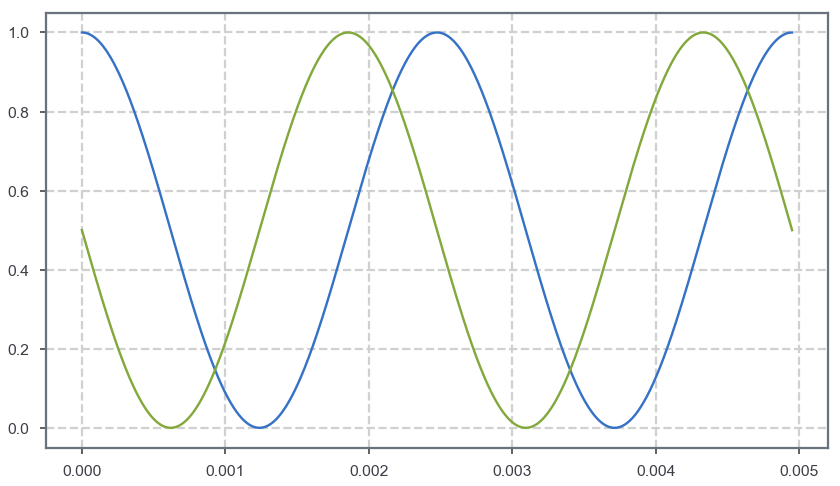

In [4]:
hamodd,hameven=genham(2,J)
initialstate=strtransferstate('10')
target=(-1j*strtransferstate('01')+strtransferstate('10')).unit()
times=np.linspace(0,2*np.pi/J,5000)
result1=qutip.mesolve(hameven,initialstate,times,[],[])
plt.figure(figsize=(14,8))
plt.plot(times,qutip.expect(qutip.ket2dm(initialstate),result1.states))
plt.plot(times,qutip.expect(qutip.ket2dm(target),result1.states))
#result1.states[int(15000/8)]

In [5]:
## basic ket
n=4
b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
b=list(set(b))
newb=[list(map(str,o)) for o in b]
strb=[''.join(o) for o in newb]
print(strb)
# statelist=[]
# statekettodmlist=[]
# for i in b:
#     tmp=qutip.basis(2,i[0])
#     for j in i[1:]:
#         tmp=qutip.tensor(tmp,qutip.basis(2,j))
#     statelist.append(tmp)
#     statekettodmlist.append(qutip.ket2dm(tmp))
#print(b)

['1010', '1100', '1001', '0110', '0101', '0011']


CPU times: user 9.28 s, sys: 246 ms, total: 9.53 s
Wall time: 15 s


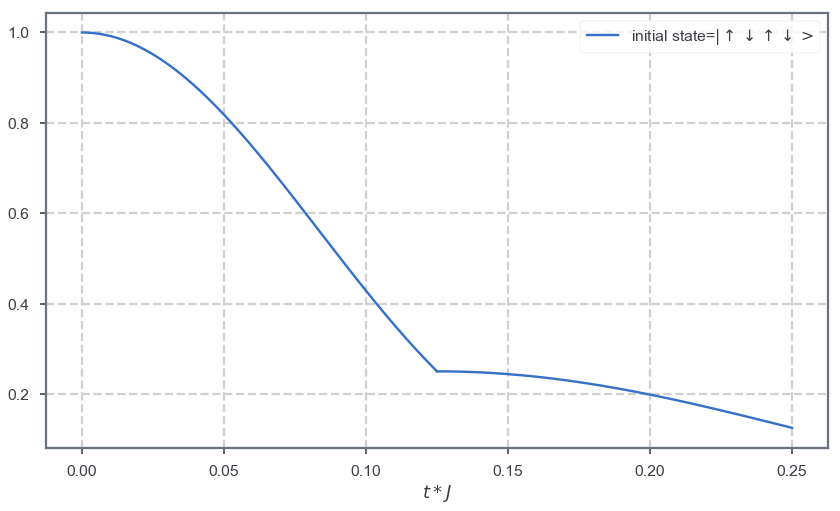

In [6]:
%%time
hamodd,hameven=genham(n,J)
initialstate=strtransferstate('10'*int(n/2))
#target=(strtransferstate('1010')-strtransferstate('0101')-1j*strtransferstate('1001')-1j*strtransferstate('0110')).unit()
times=np.linspace(0,2*np.pi/J/8,5000)
result1=qutip.mesolve(hameven,initialstate,times,[],[])
result2=qutip.mesolve(hamodd,result1.states[-1],times,[],[])
plt.figure(figsize=(14,8))
plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result1.states),c='b',label=r"initial state=$|\uparrow\downarrow\uparrow\downarrow>$")
plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result2.states),c='b')
#plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(target),result1.states))
#plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(target),result2.states))
plt.xlabel('$t*J$')
plt.legend(loc='best')

[ 3  5  6  9 10 12]
['1100' '1010' '1001' '0110' '0101' '0011']


array([-0.354-0.   j, -0.   +0.354j,  0.5  +0.   j,  0.5  +0.   j,
       -0.   -0.354j,  0.354-0.   j])

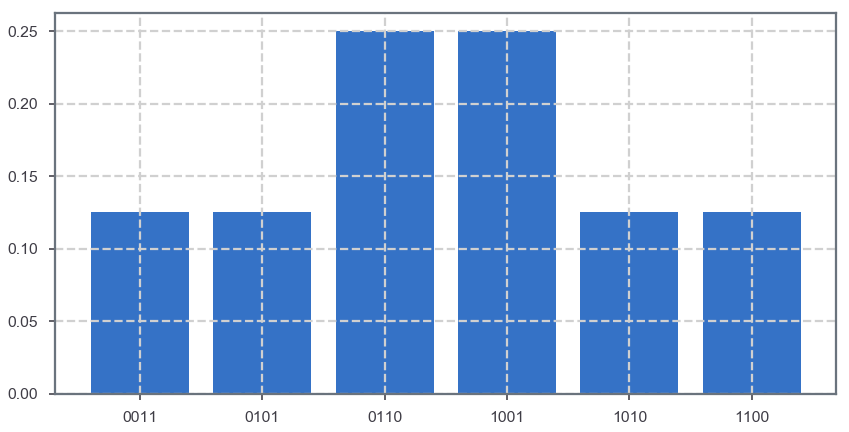

In [7]:
## for n=4 case
#n=4
# b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
# b=list(set(b))
# newb=[list(map(str,o)) for o in b]
# strb=[''.join(o) for o in newb]
indic=tsqtindtostate(n)
s=np.abs(result2.states[-1].full())**2
finalstatevector=result2.states[-1].full().reshape((1,-1))
reducespacestate=qutip.Qobj(finalstatevector[finalstatevector!=0])
location=np.where(s!=0)
print(location[0])
print(indic[location[0]])
plt.figure(figsize=(14,7))
plt.bar(indic[location[0]],s[location])
np.round(reducespacestate.full().reshape(-1,),3)

right
CPU times: user 2.37 s, sys: 58.8 ms, total: 2.43 s
Wall time: 3.35 s


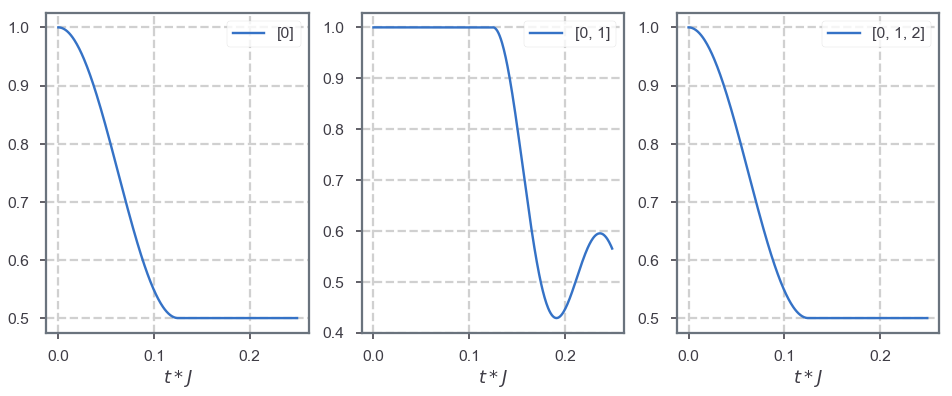

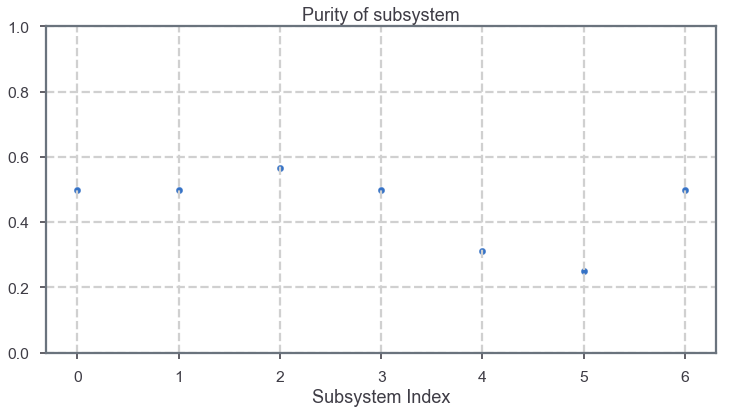

In [8]:
%%time
allpos=splittosys(n)[0]
subsystem1=list(allpos[-1])
subsystem2=list(allpos[2])
length=len(times)
ind=int(length/200)*np.arange(200)
statesin1=np.array(result1.states)[ind]
statesin2=np.array(result2.states)[ind]
statesin=np.append(statesin1,statesin2)
t2=np.append(times[ind],times[ind]+times[-1])
plt.figure(figsize=(16,20))
plt.title('1-Subsystem Purity')

for i in range(1,n):
#     length=len(i)
# #     print()
#     st1=set(list(range(length)))
#     st2=set(list(range(6)))-st1
#     if i==st1 or i==st2:
        #print(i)
    sd=list(range(i))
    rho1=np.array([entropycheck(state,sd) for state in statesin])
    plt.subplot(3,3,i)
    plt.xlabel('$t*J$')
    plt.plot(t2*J/2/np.pi,rho1,label=str(sd))
    plt.legend(loc='best')
#plt.savefig('Evolution of Subsystem Entropy.pdf')
    
finalstate=statesin[-1]
finalentrpy=[]
print('right')
for i in allpos:
    i=list(i)
    finalentrpy.append(entropycheck(finalstate,i))
plt.figure(figsize=(12,6))
plt.title('Purity of subsystem')
plt.ylim((0,1))
plt.xlabel('Subsystem Index')
plt.scatter(range(len(allpos)),finalentrpy,s=40)
#plt.savefig('Subsystem Entropy.pdf')

## Atom loss influence
when the system loss one atom after state generation, the entanglement of remain system is shown below.

All possible remain atoms config: [[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]
When the loss config is  [1, 2, 3] Not entangled pair: [([2, 3], [1])]
When the loss config is  [0, 2, 3] Not entangled pair: [([2, 3], [0])]
When the loss config is  [0, 1, 3] Not entangled pair: [([3], [0, 1])]
When the loss config is  [0, 1, 2] Not entangled pair: [([2], [0, 1])]


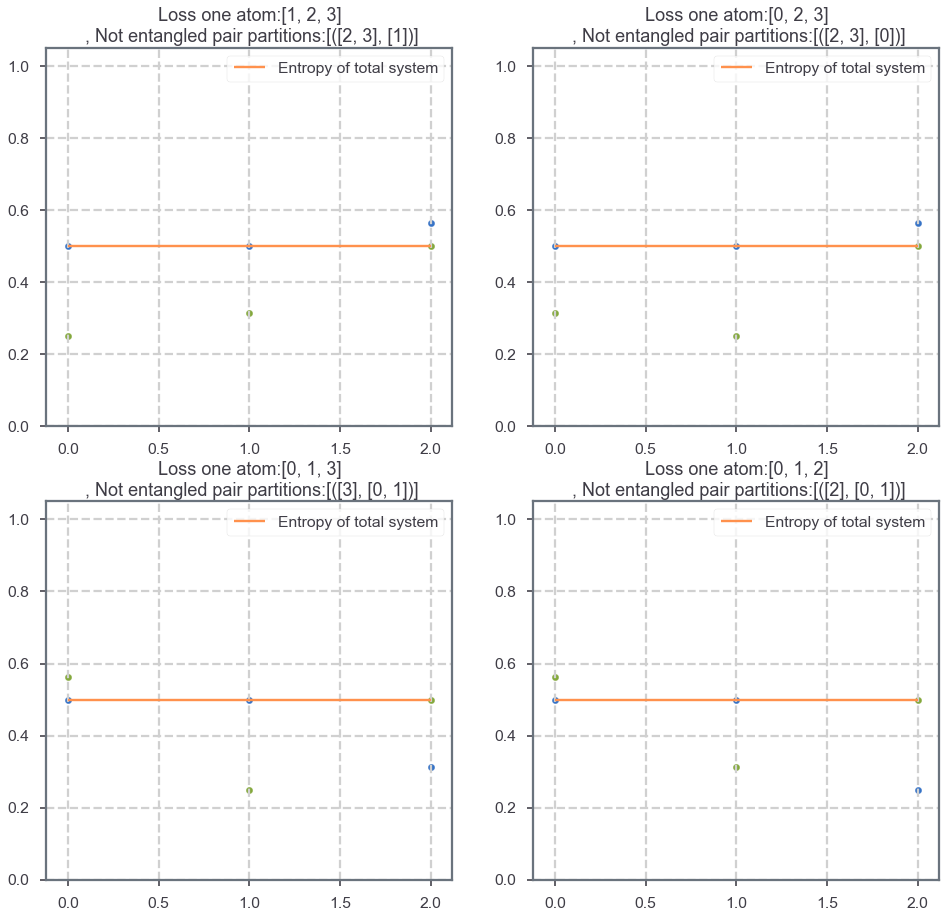

In [9]:
lossconfig=[]
for i in range(n):
    tmp=list(range(n))
    del (tmp[i])
    lossconfig.append(tmp)

print('All possible remain atoms config:',lossconfig)
allposloss0=splittosys(n-1)[0]
allposloss1=splittosys(n-1)[1]

finalstate=np.array(result2.states)[-1]
pltflag=1
plt.figure(figsize=(16,n*8))
for config in lossconfig: 
    finalentrpy0=[]
    finalentrpy1=[]
    lossstate=finalstate.ptrace(config)
    entropytotal=round(entropycheck(finalstate,config),5)
    unentangledpair=[]
    for i in range(len(allposloss0)):
        s0=list(allposloss0[i])
        s1=list(allposloss1[i])
        subentropy0=round(entropycheck(lossstate,s0),5)
        subentropy1=round(entropycheck(lossstate,s1),5)
        finalentrpy0.append(subentropy0)
        finalentrpy1.append(subentropy1)
        if subentropy0>entropytotal or subentropy1>entropytotal:
            #print(subentropy0,subentropy1)
            unentangledpair.append((list(np.array(config)[s0]),list(np.array(config)[s1])))
    plt.subplot(n,2,pltflag)
    pltflag+=1
    #plt.title('Purity of Subsystem')
    plt.ylim((0,1.05))
    plt.title('Loss one atom:'+str(config)+'\n , Not entangled pair partitions:'+str(unentangledpair))
    plt.hlines(entropytotal,0,len(allposloss0)-1,colors='y',label='Entropy of total system')
    plt.scatter(range(len(allposloss0)),finalentrpy0,s=40)
    plt.scatter(range(len(allposloss1)),finalentrpy1,s=40)
    plt.legend(loc='best')
    #print([np.array(config)[list(i)] for i in allposloss0])
    print('When the loss config is ',config,'Not entangled pair:',unentangledpair)

## 1. Non-Local Bell Inequlity Verification

Symmetric Bell inequality from J. Tura et al., Science 344, 1256–1258 (2014).

$$\alpha S_0+\beta S_1+ \gamma S_{00}/2+\sigma S_{01}+\varepsilon S_{11}/2+\beta_{c} \ge 0$$

However our final state can't violate the inequlity in this paper, since our state is not a symmetric state and symmetric states have the largest violation.

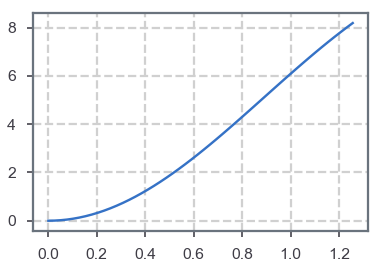

In [10]:
def calviolationofbell(state,theta0,theta1):
    #print(state)
    spintotal=totalspinoperator(n)
    spinspincorrelation=spintotal*spintotal
    m0=singleration(theta0)
    m0total=staterotation(n,m0)
    m1=singleration(theta1)
    m1total=staterotation(n,m1)
    m1timesm0=np.cos(theta0-theta1)
    absm0mlusm1=np.sqrt(2-2*m1timesm0)
    m0mlusm1=singleration((theta1+theta0)/2+np.pi/2)
    m0mlusm1total=staterotation(n,m0mlusm1)
    absm0plusm1=np.sqrt(2+2*m1timesm0)
    m0plusm1=singleration((theta1+theta0)/2)
    m0plusm1total=staterotation(n,m0plusm1)

    s0=2*qutip.expect(spintotal,m0total*state)
    s1=2*qutip.expect(spintotal,m1total*state)
    s11=4*qutip.expect(spinspincorrelation,m1total*state)-n
    s00=4*qutip.expect(spinspincorrelation,m0total*state)-n
    s01=1*((absm0plusm1)**2*qutip.expect(spinspincorrelation,m0plusm1total*state)-
              (absm0mlusm1)**2*qutip.expect(spinspincorrelation,m0mlusm1total*state))-n*m1timesm0

#     alpha=n*(n-1)*(np.ceil(n/2)-n/2)
#     beta=alpha/n
#     gama=n*(n-1)/2
#     sigma=n/2
#     ebxl=-1
#     betac=0.5*n*(n-1)*np.ceil((n+2)/2)

    alpha=2
    beta=0
    gama=1
    sigma=1
    ebxl=1
    betac=2*n

    #     alpha=0
    #     beta=0
    #     gama=0
    #     sigma=0
    #     ebxl=-1
    #     betac=12

    #betac,alpha,beta,gama,sigma,ebxl=12,3,3,0,1,0


    belleq=alpha*s0+beta*s1+gama*s00/2+sigma*s01+ebxl*s11/2+betac
    return belleq

dickestate=(strtransferstate('1100')
                +strtransferstate('1010')
                +strtransferstate('1001')
                +strtransferstate('0011')
                +strtransferstate('0101')
                +strtransferstate('0110')).unit()



verdicke=[]
for th in np.linspace(0,0.4,50):
    verdicke.append(calviolationofbell(dickestate,0,th*np.pi))
plt.plot(np.linspace(0,0.4,50)*np.pi,verdicke)

statecheck=result2.states[-1]
    
theta0list=np.linspace(0,1,30)*np.pi
theta1list=np.linspace(0,1,30)*np.pi
total = len(theta0list)*len(theta1list)
bellall=[]

for theta0 in theta0list:
    for theta1 in theta1list:
        bellall.append(calviolationofbell(statecheck,theta0,theta1))

bellall = np.array(bellall)
bellall = bellall.reshape((len(theta0list),len(theta1list)))

0.0


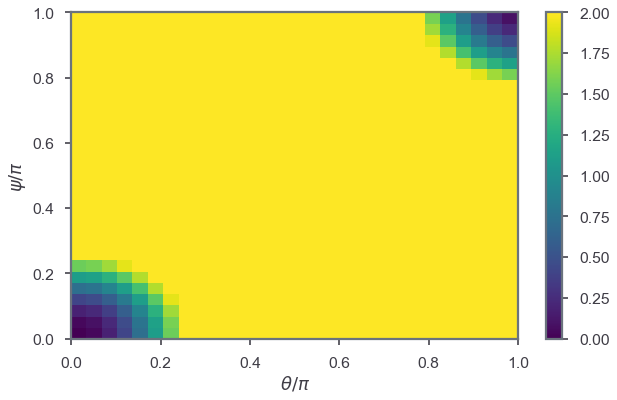

In [11]:
print(np.min(bellall))
plt.figure(figsize=(10,6))
plt.xlabel('$\\theta/\pi$')
plt.ylabel('$\\psi/\pi$')
#plt.ylim((-0.038,0))
plt.pcolor(theta0list/(np.pi),theta1list/(np.pi),bellall,vmax=2)
#plt.plot(np.linspace(0,0.4*np.pi,50)/np.pi,bell)
plt.colorbar()

## 2. Squeezing parameter

According to the paper A. Sørensen, L.-M. Duan, J. I. Cirac, and P. Zoller , Nature (London) 409, 63 (2001), we can define a squeezing parameter:
$$\xi^{2}=\frac{N(\Delta J_{z})^2}{<J_{x}>^2+<J_{y}>^2}$$

if $\xi^2<1$, this state is spin squeezed, and it is also entangled.

Another spin squeezing parameter for states with $<J_{x}>,<J_{y}>,<J_{z}>=0$, Dicke squeezing parameter:

$$\xi^{2}=\frac{N((\Delta J_{z})^2+1/4)}{<J_{x}^2+J_{y}^2>}$$

In [12]:
def calsqueez(state):
    spintotal=totalspinoperator(n)
    spintotaly=totalspinyoperator(n)
    spinspincorrelation=spintotal*spintotal
    spinspinycorrelation=spintotaly*spintotaly
    mx=singleration(np.pi/2)
    mxtotal=staterotation(n,mx)
    my=qutip.Qobj(0.5**0.5*np.array([(1,-1j),(-1,-1j)]))
    mytotal=staterotation(n,my)
    averagex=qutip.expect(spintotal,mxtotal*state)
    averagey=qutip.expect(spintotaly,state)
    averagez=qutip.expect(spintotal,state)
    averagexsq=qutip.expect(spinspincorrelation,mxtotal*state)
    averageysq=qutip.expect(spinspinycorrelation,state)
    averagezsq=qutip.expect(spinspincorrelation,state)
    variancex=averagexsq-averagex**2
    variancey=averageysq-averagey**2
    variancez=averagezsq-averagez**2
    print(averagex,averagey,averagez)
    print(averagexsq,averageysq,averagezsq)
    print(variancex,variancey,variancez)
    tmp0=(n-1)*(variancey+variancez)-averagexsq-n*(n-2)/4
    tmp1=variancez+variancex+variancey-0.5*n
    tmp2=(n-1)*variancez+0.5*n-averageysq-averagexsq#n*variancez/(n**2-averagez**2)
    tmp3=n*(variancez+0.25)/(averagexsq+averageysq)
    return tmp0,tmp1,tmp2,tmp3
    
dickestate0=(qutip.tensor(qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1))
                +0.j*qutip.tensor(qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,0))
                +0.j*qutip.tensor(qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,0))
                +0.j*qutip.tensor(qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,1))).unit()

dickestate1=(qutip.tensor(qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,1))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,1))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1))).unit()

print(calsqueez(dickestate))
print(calsqueez(result2.states[-1]))

0.0 0.0 0.0
3.0000000000000004 3.0000000000000004 0.0
3.0000000000000004 3.0000000000000004 0.0
(4.000000000000002, 4.000000000000001, -4.000000000000001, 0.16666666666666663)
2.7755575615628914e-17 0.0 0.0
0.9993911180894559 0.999391118089456 0.0
0.9993911180894559 0.999391118089456 0.0
(-0.0012177638210879582, -0.0012177638210881803, 0.0012177638210879582, 0.5003046264367988)


## Non-separability criteria

Use the inequality from the paper 'Entanglement between two spatially separated atomic modes'

In [13]:
def calnonsepar(state,n=n):
    spintotal=totalspinoperator(n)
    spintotaly=totalspinyoperator(n)
    spintotalx=totalspinxoperator(n)
    spinspincorrelation=spintotal*spintotal
    spinspinycorrelation=spintotaly*spintotaly
    spinspinxcorrelation=spintotalx*spintotalx
    averagex=qutip.expect(spintotalx,state)
    averagey=qutip.expect(spintotaly,state)
    averagez=qutip.expect(spintotal,state)
    averagexsq=qutip.expect(spinspinxcorrelation,state)
    averageysq=qutip.expect(spinspinycorrelation,state)
    averagezsq=qutip.expect(spinspincorrelation,state)
    variancex=averagexsq-averagex**2
    variancey=averageysq-averagey**2
    variancez=averagezsq-averagez**2
    aver=(averagex,averagey,averagez)
    aversq=(averagexsq,averageysq,averagezsq)
    varian=(variancex,variancey,variancez)
    return aver,aversq,varian

    
dickestate0=(qutip.tensor(qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,0))
                +1*qutip.tensor(qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,0))
                +0.j*qutip.tensor(qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,0))
                +0.j*qutip.tensor(qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,1))).unit()

dickestate1=(qutip.tensor(qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,1))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,1))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1))).unit()

state0=dickestate#result2.states[-1]
allsys=calnonsepar(state0,n=4)
suba=calnonsepar(qutip.ptrace(state0,[0,1]),n=2)
subb=calnonsepar(qutip.ptrace(state0,[2,3]),n=2)
DeltaJzplus=allsys[2][2]

a=[0,1]
b=[2,3]
BigJa=qutip.expect(totalspinxpar(n,a)*totalspinxpar(n,a)+totalspinypar(n,a)*totalspinypar(n,a),state0)
BigJa=BigJa**0.5/(n/4)
BigJb=qutip.expect(totalspinxpar(n,b)*totalspinxpar(n,b)+totalspinypar(n,b)*totalspinypar(n,b),state0)
BigJb=BigJb**0.5/(n/4)
Jxmius=qutip.expect((totalspinxpar(n,a)/((n/4)*BigJa)
                    -totalspinxpar(n,b)/((n/4)*BigJb))*(totalspinxpar(n,a)/((n/4)*BigJa)
                    -totalspinxpar(n,b)/((n/4)*BigJb)),state0)
Jymius=qutip.expect((totalspinypar(n,a)/((n/4)*BigJa)
                    -totalspinypar(n,b)/((n/4)*BigJb))*(totalspinypar(n,a)/((n/4)*BigJa)
                    -totalspinypar(n,b)/((n/4)*BigJb)),state0)

f=(BigJa**2+BigJb**2-1)**2/(BigJa*BigJb)
#A=suba[1][0]+suba[1][1]+subb[1][0]+subb[1][1]
smal=Jxmius+Jymius
smal*(DeltaJzplus+0.5),f

In [14]:
np.linspace(0,np.pi,60)

array([0.        , 0.05324733, 0.10649467, 0.159742  , 0.21298933,
       0.26623667, 0.319484  , 0.37273133, 0.42597866, 0.479226  ,
       0.53247333, 0.58572066, 0.638968  , 0.69221533, 0.74546266,
       0.79871   , 0.85195733, 0.90520466, 0.958452  , 1.01169933,
       1.06494666, 1.118194  , 1.17144133, 1.22468866, 1.27793599,
       1.33118333, 1.38443066, 1.43767799, 1.49092533, 1.54417266,
       1.59741999, 1.65066733, 1.70391466, 1.75716199, 1.81040933,
       1.86365666, 1.91690399, 1.97015133, 2.02339866, 2.07664599,
       2.12989332, 2.18314066, 2.23638799, 2.28963532, 2.34288266,
       2.39612999, 2.44937732, 2.50262466, 2.55587199, 2.60911932,
       2.66236666, 2.71561399, 2.76886132, 2.82210865, 2.87535599,
       2.92860332, 2.98185065, 3.03509799, 3.08834532, 3.14159265])

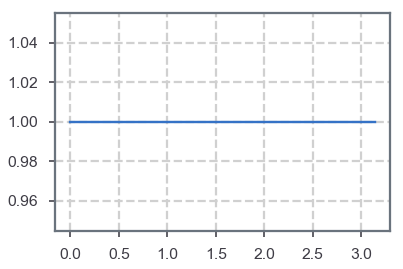

In [15]:
z=1*qutip.sigmaz()
li=[]
for theta in np.linspace(0,np.pi,100):
    x=np.cos(theta)*qutip.sigmax()+np.sin(theta)*qutip.sigmay()
    #x2=np.cos(0)*qutip.sigmax()+np.sin(0)*qutip.sigmay()
    tmp=qutip.qeye(2)
    operator1=0.5*(qutip.tensor(x,z,tmp,tmp)+qutip.tensor(tmp,tmp,tmp,tmp))
    operator2=0.5*(qutip.tensor(tmp,z,x,z)+qutip.tensor(tmp,tmp,tmp,tmp))
    operator3=0.5*(qutip.tensor(z,x,z,tmp)+qutip.tensor(tmp,tmp,tmp,tmp))
    operator4=0.5*(qutip.tensor(tmp,tmp,z,x)+qutip.tensor(tmp,tmp,tmp,tmp))
    state=result2.states[-1]
#     state=(strtransferstate('1111')
#                     +strtransferstate('0111')
#                     +strtransferstate('1011')
#                     -strtransferstate('0011')
#                     +strtransferstate('1101')
#                     +strtransferstate('0101')
#            -strtransferstate('1001')
#            +strtransferstate('0001')
#            +strtransferstate('1110')
#           +strtransferstate('0110')
#           +strtransferstate('1010')
#           -strtransferstate('0010')
#           -strtransferstate('1100')
#           -strtransferstate('0100')
#           +strtransferstate('1000')
#           -strtransferstate('0000')).unit()
    sm1=qutip.expect(operator1,state)*qutip.expect(operator2,state)
    sm2=qutip.expect(operator3,state)*qutip.expect(operator4,state)
    li.append(1.5-(sm2+sm1))
plt.plot(np.linspace(0,np.pi,100),li)

In [26]:
z=qutip.sigmaz()
x=qutip.sigmax()
y=qutip.sigmay()
state=(strtransferstate('1100')
                +strtransferstate('0011')
                +0*strtransferstate('0101')
                +0*strtransferstate('0110')).unit()#result1.states[1]#x2=np.cos(0)*qutip.sigmax()+np.sin(0)*qutip.sigmay()
tmp=qutip.qeye(2)
operator1=np.abs(qutip.expect(qutip.tensor(x,x,tmp,tmp),state))+np.abs(qutip.expect(qutip.tensor(tmp,tmp,x,x),state))
+np.abs(qutip.expect(qutip.tensor(tmp,x,x,tmp),state))+np.abs(qutip.expect(qutip.tensor(x,tmp,x,tmp),state))
+np.abs(qutip.expect(qutip.tensor(x,tmp,tmp,x),state))+np.abs(qutip.expect(qutip.tensor(tmp,x,tmp,x),state))

operator2=np.abs(qutip.expect(qutip.tensor(y,y,tmp,tmp),state))+np.abs(qutip.expect(qutip.tensor(tmp,tmp,y,y),state))
+np.abs(qutip.expect(qutip.tensor(tmp,y,y,tmp),state))+np.abs(qutip.expect(qutip.tensor(y,tmp,y,tmp),state))
+np.abs(qutip.expect(qutip.tensor(y,tmp,tmp,y),state))+np.abs(qutip.expect(qutip.tensor(tmp,y,tmp,y),state))

operator3=np.abs(qutip.expect(qutip.tensor(z,z,tmp,tmp),state))+np.abs(qutip.expect(qutip.tensor(tmp,tmp,z,z),state))
+np.abs(qutip.expect(qutip.tensor(tmp,z,z,tmp),state))+np.abs(qutip.expect(qutip.tensor(z,tmp,z,tmp),state))
+np.abs(qutip.expect(qutip.tensor(z,tmp,tmp,z),state))+np.abs(qutip.expect(qutip.tensor(tmp,z,tmp,z),state))

print((6+operator1+operator2+operator3)/24,3/8+3**0.5/8)

#     state=(strtransferstate('1111')
#                     +strtransferstate('0111')
#                     +strtransferstate('1011')
#                     -strtransferstate('0011')
#                     +strtransferstate('1101')
#                     +strtransferstate('0101')
#            -strtransferstate('1001')
#            +strtransferstate('0001')
#            +strtransferstate('1110')
#           +strtransferstate('0110')
#           +strtransferstate('1010')
#           -strtransferstate('0010')
#           -strtransferstate('1100')
#           -strtransferstate('0100')
#           +strtransferstate('1000')
#           -strtransferstate('0000')).unit()

0.3333333333333333 0.5915063509461096


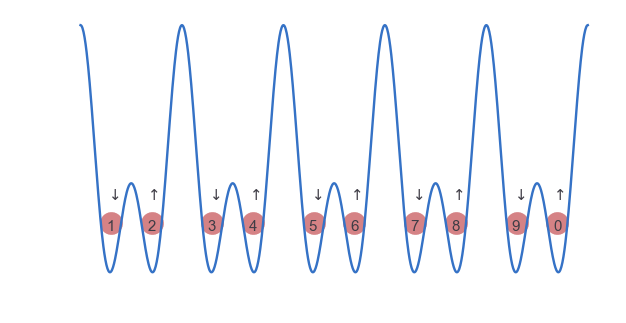

In [192]:
import matplotlib.patches as mpatches
x=np.linspace(0,5,1000)
#y=np.linspace(0,5,1000)
fig,ax=plt.subplots(figsize=(10,5))
#fig.figure()
ax.grid('off')
ellipse = mpatches.Ellipse([0.5,0.75], 0.8, 0.2, color= "y")

plt.box('off')
plt.axis('off')
ax.plot(x,(np.cos(2*np.pi*x))**2+(np.sin(np.pi*x+0.5*np.pi))**2)
ax.scatter([0.3+i for i in range(5)]+[0.7+i for i in range(5)],[0.75]*10,c='r',s=500,alpha=0.7)
for i in range(5):
    ax.text(0.25+i,0.7,str(2*i+1),fontsize=15)
    ax.text(0.25+i,0.9,"$\\downarrow$",fontsize=15)
    ax.text(0.66+i,0.7,str((2*i+2)%10),fontsize=15)
    ax.text(0.64+i,0.9, "$\\uparrow$",fontsize=15)
#ax.add_patch(ellipse)
plt.savefig('1.pdf')

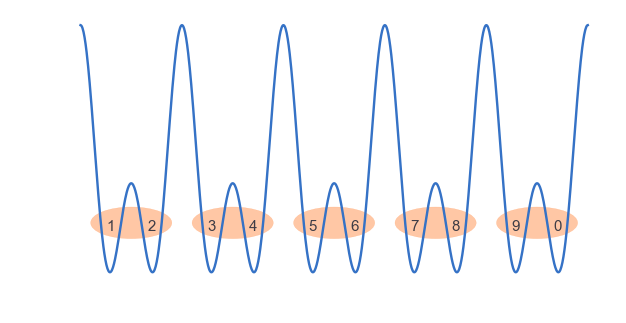

In [782]:
x=np.linspace(0,5,1000)
#y=np.linspace(0,5,1000)
fig,ax=plt.subplots(figsize=(10,5))
#fig.figure()
ax.grid('off')


plt.box('off')
plt.axis('off')
ax.plot(x,(np.cos(2*np.pi*x))**2+(np.sin(np.pi*x+0.5*np.pi))**2)
#ax.scatter([0.3+i for i in range(5)]+[0.7+i for i in range(5)],[0.75]*10,c='r',s=500)
for i in range(5):
    ax.text(0.25+i,0.7,str(2*i+1),fontsize=15)
    ax.text(0.66+i,0.7,str((2*i+2)%10),fontsize=15)
    ellipse = mpatches.Ellipse([0.5+i,0.75], 0.8, 0.2, color= "y",alpha=0.5)
    ax.add_patch(ellipse)
plt.savefig('2.pdf')

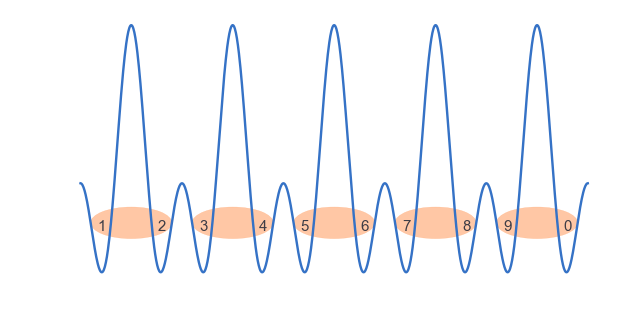

In [783]:
x=np.linspace(0,5,1000)
#y=np.linspace(0,5,1000)
fig,ax=plt.subplots(figsize=(10,5))
#fig.figure()
ax.grid('off')


plt.box('off')
plt.axis('off')
ax.plot(x,(np.cos(2*np.pi*x))**2+(np.sin(np.pi*x+0*np.pi))**2)
#ax.scatter([0.3+i for i in range(5)]+[0.7+i for i in range(5)],[0.75]*10,c='r',s=500)
for i in range(5):
    ax.text(0.17+i,0.7,str(2*i+1),fontsize=15)
    ax.text(0.76+i,0.7,str((2*i+2)%10),fontsize=15)
    ellipse = mpatches.Ellipse([0.5+i,0.75], 0.8, 0.2, color= "y",alpha=0.5)
    ax.add_patch(ellipse)
plt.savefig('3.pdf')

In [ ]:
x=np.linspace(0,5,1000)
#y=np.linspace(0,5,1000)
fig,ax=plt.subplots(figsize=(10,5))
#fig.figure()
ax.grid('off')


plt.box('off')
plt.axis('off')
ax.plot(x,(np.cos(2*np.pi*x))**2+(np.sin(np.pi*x+0*np.pi))**2)
#ax.scatter([0.3+i for i in range(5)]+[0.7+i for i in range(5)],[0.75]*10,c='r',s=500)
for i in range(5):
    ax.text(0.15+i,0.7,str(2*i+1),fontsize=15)
    ax.text(0.73+i,0.7,str((2*i+2)%10),fontsize=15)
    ellipse = mpatches.Ellipse([0.5+i,0.75], 0.8, 0.2, color= "y",alpha=0.5)
    ax.add_patch(ellipse)
    if i!=4:
        ellipse = mpatches.Ellipse([1+i,0.75], 0.8, 0.2, color= 'y',alpha=0.5)
        ax.add_patch(ellipse)
plt.savefig('4.pdf')

In [ ]:
10//3